<h1> Dynamic Topic Modelling using LDA </h1>

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import gensim
import matplotlib.pyplot as plt
#import pyLDAvis
#import pyLDAvis.gensim_models
import csv

#from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.feature_extraction.text import CountVectorizer
#from gensim.models.coherencemodel import CoherenceModel

# setting up our imports
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
#from gensim.models.wrappers.dtmmodel import DtmModel

<h1> 1. Load data and treat </h1>

In [2]:
# Import the final tokens
#f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/FR_meta_and_final_tokens_21SEPT14.pkl', 'rb')
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Tech-Report/case_studies/coronavirus_corpus.pkl', 'rb')
df = pickle.load(f)
f.close()
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,...,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
5122,5122,5608,95622,Host - virus interactions are greatly affected...,2008,Affect; Antiviral Agents; Area; Biochemical; D...,THE ROLE OF A HOST ION PUMP IN RNA VIRUS RECOM...,NSF,NSF,NaN,...,UNITED STATES,NaN,NaN,47.074,2008,612000.0,NaN,1,1,"[host, virus, interaction, greatly, affect, ex..."
13938,13938,15726,152221,AbstractThe American Society for Virology (ASV...,2008,abstracting; Acquired Immunodeficiency Syndrom...,"INTERNATIONAL CONGRESS OF VIROLOGY, ISTANBUL, ...",HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2009,93.855,2008,30000.0,NaN,1,1,"[american, society, virology_asv, wish, provid..."
14418,14418,17118,153617,DESCRIPTION (provided by applicant): Severe a...,2008,Abbreviations; Address; Alleles; Alphavirus; A...,SARS REVERSE GENETICS,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,271608.0,NaN,1,1,"[severe, acute, respiratory, syndrome, life_th..."
14514,14514,17384,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,75292.0,NaN,1,1,"[human, coronaviruse_hcov, initially, identify..."
14565,14565,17526,154033,"DESCRIPTION: Plus-stranded RNA viruses, which ...",2008,Affect; Agriculture; Animals; Antiviral Agents...,ROLES OF HOST RNA BINDING PROTEINS IN VIRUS RE...,HHS,NIH,NIAID,...,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,200124.0,NaN,1,1,"[strand, rna, virus, pose, significant, risk, ..."


In [3]:
# Count the number of Abstracts by year. PROJECT_START_DATE doesn't have missing informations= uses it for the time slice
df.columns

Index(['index', 'original index', 'PROJECT_ID', 'ABSTRACT', 'FY',
       'PROJECT_TERMS', 'PROJECT_TITLE', 'DEPARTMENT', 'AGENCY', 'IC_CENTER',
       'PROJECT_NUMBER', 'PROJECT_START_DATE', 'PROJECT_END_DATE',
       'CONTACT_PI_PROJECT_LEADER', 'OTHER_PIS', 'CONGRESSIONAL_DISTRICT',
       'DUNS_NUMBER', 'ORGANIZATION_NAME', 'ORGANIZATION_CITY',
       'ORGANIZATION_STATE', 'ORGANIZATION_ZIP', 'ORGANIZATION_COUNTRY',
       'BUDGET_START_DATE', 'BUDGET_END_DATE', 'CFDA_CODE', 'FY.y',
       'FY_TOTAL_COST', 'FY_TOTAL_COST_SUB_PROJECTS', 'ORG_COUNT', 'PI_COUNT',
       'final_tokens'],
      dtype='object')

In [4]:
# length (number of abstract) of the coronavirus sample
print(len(df), "Abstracts")

1022 Abstracts


In [5]:
# Function to compute the corpus and dictionary for the DTM LDA
def createLDAvars(docs):

    # Create the variables needed for LDA from df[final_frqwds_removed]: dictionary (id2word), corpus
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    #Filter words to only those found in at least a set number of documents (min_appearances)
    id2word.filter_extremes(no_below=20, no_above=0.6)
    
    # filter out stop words - "use" already filtered out by previous line
    id2word.filter_tokens(bad_ids=[id2word.token2id['research'], id2word.token2id['project']])

    # Create Corpus (Term Document Frequency)

    #Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
    # corpus not need for c_v coherence
    corpus = [id2word.doc2bow(doc) for doc in docs]

    return id2word, corpus

In [6]:
# build the dictionary id2word
docs = df["final_tokens"]
[dictionary, corpus] = createLDAvars(docs)

In [7]:
# Create the time slice using the fiscal year
df['Year'] = df['FY']
time_slice = df['PROJECT_ID'].groupby(df['Year']).count()

<h2> 3. Solve a dynamic topic model </h2>

In [ ]:
# Run the DMT. Pre-training model (default chain_variance=0.005)
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=30)

# save to file
pickle.dump(ldaseq, open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/DTM_LDA_30.pkl','wb'))

<h2> 3.1. Run slurm for the result for the DTM-LDA (k=30) <h2/>

In [8]:
# Load the pickle result from slurm
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/DTM_LDA_30.pkl', 'rb')
ldaseq = pickle.load(f)
f.close()

In [9]:
# Print the list of topics a given time
topic_list = ldaseq.print_topics(time=0, top_terms=10)
topic_words = []

for i in range(len(topic_list)):
    topic_words.append([item[0] for item in topic_list[i]])

# Print the list of topics 
pd.DataFrame(topic_words)

# Save the result in csv
with open('Topic_list_0.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(topic_words)

In [10]:
# Time evolution of the first topic. Combine the whole time evolution in a DataFrame
time_topic = ldaseq.print_topic_times(topic=1, top_terms=10)
time = list(time_slice.index)
topic_evol = pd.DataFrame(time_topic[0])
topic_evol.columns = ['WORDS', str(time[0])]

for i in range(1,len(time_topic)):
    year_topic = pd.DataFrame(time_topic[i])
    year_topic.columns = ['WORDS', str(time[i])]
    topic_evol = topic_evol.merge(year_topic, how='outer', on=['WORDS'])

# Print the topic evolution. Detect some news words (max=30 words)
topic_evol = topic_evol.fillna(0)
topic_evol.head(30)

# Save the result in csv
#topic_evol.to_csv('Topic_evol_1.csv')

,WORDS,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,sars_cov,0.045879,0.037755,0.030031,0.024233,0.020971,0.018965,0.017617,0.016542,0.015723,0.000000,0.000000,0.000000
1,cell,0.032409,0.032067,0.031273,0.032645,0.033113,0.033249,0.033166,0.032361,0.030986,0.029544,0.028446,0.027601
2,mouse,0.028066,0.029179,0.032504,0.036035,0.039234,0.040516,0.040959,0.042136,0.043012,0.044317,0.045365,0.046382
3,response,0.026005,0.027769,0.030515,0.034751,0.038852,0.042256,0.044196,0.044144,0.042624,0.040295,0.039057,0.039066
4,sars,0.025407,0.022997,0.020163,0.017145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,disease,0.022310,0.023690,0.025978,0.027285,0.028146,0.029279,0.030305,0.031140,0.032445,0.033410,0.034013,0.033882
6,respiratory,0.022126,0.022793,0.023570,0.023998,0.023846,0.023436,0.023191,0.023360,0.024035,0.024606,0.025131,0.025624
7,severe,0.019491,0.020599,0.022442,0.024334,0.025116,0.025742,0.025939,0.025537,0.024639,0.023777,0.023182,0.022897
8,cause,0.017656,0.018164,0.017708,0.017098,0.016721,0.016452,0.016506,0.016744,0.017519,0.018333,0.018626,0.018716
9,aim,0.016827,0.016667,0.016690,0.017445,0.017832,0.017871,0.017750,0.017599,0.017359,0.017163,0.016979,0.016629


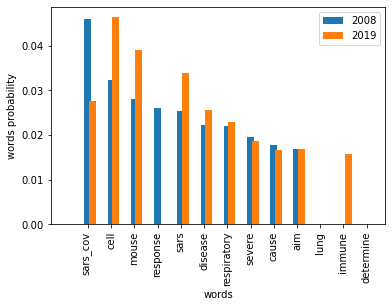

In [11]:
# Plot the word distribution
width = 0.3
ind = np.arange(len(topic_evol['WORDS']))
plt.bar(ind+0.4, topic_evol['2008'], width, label="2008")
plt.bar(ind-0.4, topic_evol['2019'], width, label="2019")
plt.legend(loc="upper right", bbox_to_anchor=(1, 1), ncol=1)
plt.xticks(ind+0.4, topic_evol['WORDS'], rotation=90)
plt.xlabel("words")
plt.ylabel("words probability")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/graph/topic_distribution.png', dpi=300, bbox_inches = "tight")

In [14]:
# For each topic compute the distribution and compare with
topic = 30
topic_change = []

for num in range (0,topic-1):
    
    # Evolution in topic distribution
    time_topic = ldaseq.print_topic_times(topic=num, top_terms=10)
    time = list(time_slice.index)
    topic_evol = pd.DataFrame(time_topic[0])
    topic_evol.columns = ['WORDS', str(time[0])]

    for i in range(1,len(time_topic)):
        year_topic = pd.DataFrame(time_topic[i])
        year_topic.columns = ['WORDS', str(time[i])]
        topic_evol = topic_evol.merge(year_topic, how='outer', on=['WORDS'])

    # fill nan value
    topic_evol = topic_evol.fillna(0)
    
    # Compute the change in topic distribution over the time
    change_value = []
    for i in range(0,len(time)-1):
        gap = np.power((topic_evol[str(time[i+1])] - topic_evol[str(time[1])]), 2)
        gapsum = gap.sum()
        dist = np.sqrt(gapsum)
        change_value.append(dist)
    
    # Combine the variation in the change of topic distribution
    topic_change.append(change_value)
    

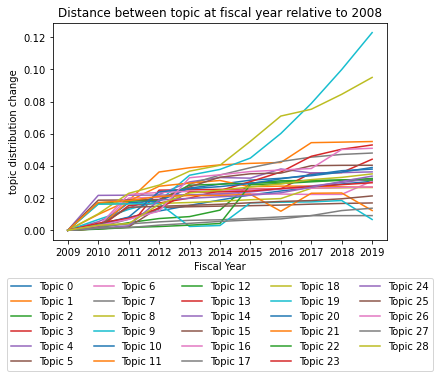

In [15]:
#  Plot the topic change pattern
for num in range (0,topic-1):
    change = pd.Series(topic_change[num], index =time[1:len(time)])
    plt.plot(change, label='Topic '+str(num))

plt.legend(loc="upper right", bbox_to_anchor=(1.15, -0.15), ncol=5)
plt.title('Distance between topic at fiscal year relative to 2008')
plt.xlabel("Fiscal Year")
plt.ylabel("topic distribution change")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/graph/distance_change.png')

<h3> 3.2. Compute the topic coherence <h3 />

Text(0, 0.5, 'Coherence')

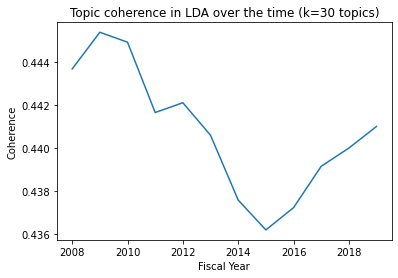

In [15]:
# Compute model coherence. Show the trend evolution and compute the golbal coherence as the average coherence over the time
coherence_values = []

for t in range(0,len(time)):
    topics_dtm = ldaseq.dtm_coherence(time=t)
    cm = CoherenceModel(topics=topics_dtm, dictionary=dictionary, texts=docs, coherence='c_v', processes=30) 
    coherence_values.append(cm.get_coherence())
    
#  Create a coherence series from the list. compute also the median....
coherence_serie = pd.Series(coherence_values, index =time)
serie = coherence_serie.plot()
plt.title('Topic coherence in LDA over the time (k=30 topics)')
plt.xlabel("Fiscal Year")
plt.ylabel("Coherence")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/graph/time_coherence.png')

In [33]:
print('The average coherence is :',coherence_serie.mean())

The average coherence is : 0.44078578516504213


<h2> 3. Find the best dynamic LDA Topic modelling </h2>

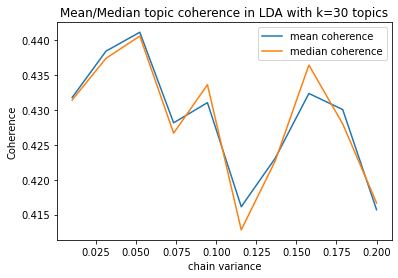

In [36]:
# 1. What is the best chain variance for a given number of topic k=30
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/Coherence_mean_30.pkl', 'rb')
coherence_mean_serie = pickle.load(f)
f.close()

# Chain variance. Map the average coherence when the chain variance change and k=30
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/Coherence_median_30.pkl', 'rb')
coherence_median_serie = pickle.load(f)
f.close()

# plot the average coherence for each value of variance
plt.plot(coherence_mean_serie, label='mean coherence')
plt.plot(coherence_median_serie, label='median coherence')
plt.title('Mean/Median topic coherence in LDA with k=30 topics')
plt.legend(loc="upper right", bbox_to_anchor=(1, 1), ncol=1)
plt.xlabel("chain variance")
plt.ylabel("Coherence")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/graph/chain_coherence_mean.png')

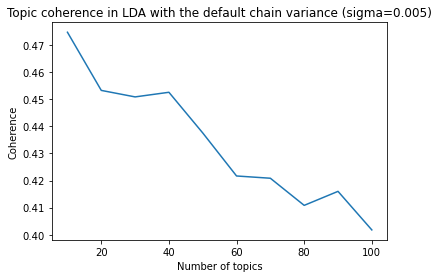

In [37]:
# Compute the coherence for the DTM-LDA using the default chain variance =0.05
topic_vec = list(range(10,101,10))
coherence_vec = []

for k in topic_vec:
    f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/coherence_%d.pkl' %k, 'rb') 
    coherence = pickle.load(f)
    f.close()
    coherence_vec.append(coherence)
    
# Plot the series of the average topic coherence
coherence_tk = pd.Series(coherence_vec, index =topic_vec)
serie = coherence_tk.plot()
plt.title('Topic coherence in LDA with the default chain variance (sigma=0.005)')
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/graph/coherence_topic_default.png')

In [39]:
# Compute a 3-D map that show the coherence for each chain-variance and number of topic
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/coherence_map.pkl', 'rb')
coherence_median_serie = pickle.load(f)
f.close()

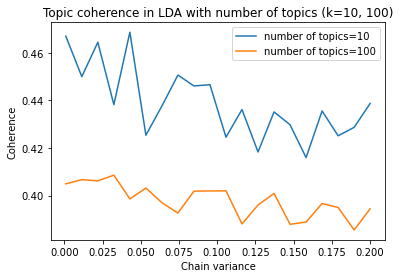

In [40]:
# Print the result.
chain_vec = np.linspace(0.001, 0.2, num = 20)
coherence_ts10 = pd.Series(coherence_median_serie[0], index =chain_vec)
coherence_ts100 = pd.Series(coherence_median_serie[1], index =chain_vec)

plt.plot(coherence_ts10, label='number of topics=10')
plt.plot(coherence_ts100, label='number of topics=100')
plt.title('Topic coherence in LDA with number of topics (k=10, 100)')
plt.legend(loc="upper right", bbox_to_anchor=(1, 1), ncol=1)
plt.xlabel("Chain variance")
plt.ylabel("Coherence")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/LDA/graph/Meancoherence_topic_chain.png')

<h2> 3. Compute topic weight </h2>